# Demonstration of GeoDataset capabilities

This first code block is only needed because this notebook is in a different directory than the source code, users will not normally need to add this if `torchgeo` is installed to a system location.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import random
import sys

os.environ["PROJ_LIB"] = "/anaconda/envs/azureml_py38/share/proj"
random.seed(1)
sys.path.insert(0, os.path.join("..", ".."))

## Import libraries

These libraries will be used later in the demo.

In [2]:
import cartopy.crs as ccrs
from rasterio.crs import CRS
from torch.utils.data import DataLoader

from torchgeo.datasets import BoundingBox, CDL, collate_dict, Landsat8
from torchgeo.samplers import RandomGeoSampler

## Define datasets

First, we define two datasets, one for Landsat 8 imagery, and one for the Cropland Data Layer (CDL) labels.

In [3]:
ROOT = "/mnt/blobfuse/adam-scratch"

crs = CRS.from_epsg(32616)
projection = ccrs.UTM(16)
transform = ccrs.UTM(16)
landsat = Landsat8(root=ROOT, crs=crs, bands=["B4", "B3", "B2"])
cdl = CDL(root=ROOT, crs=crs)

## Combine datasets

Next, we combine both `GeoDataset`s into a single `ZipDataset`.

In [4]:
print(landsat)
print(cdl)

dataset = landsat + cdl

print(dataset)

Landsat8 Dataset
    type: GeoDataset
    bbox: BoundingBox(minx=230385.0, maxx=468315.0, miny=4346385.0, maxy=4585215.0, mint=1596672000.0, maxt=1624320000.0)
CDL Dataset
    type: GeoDataset
    bbox: BoundingBox(minx=-2875406.062734979, maxx=2102487.8979590302, miny=2618997.3856099695, maxy=6177046.172886786, mint=1199145600.0, maxt=1609459199.0)
ZipDataset Dataset
    type: ZipDataset
    bbox: BoundingBox(minx=230385.0, maxx=468315.0, miny=4346385.0, maxy=4585215.0, mint=1596672000.0, maxt=1609459199.0)


## Define sampler

In order to sample from this dataset, we need to define a `GeoSampler`.

In [5]:
roi = dataset.bounds
sampler = RandomGeoSampler(roi, size=3000, length=10)

## Define data loader

This data loader combines the dataset and sampler, and allows for efficient sampling of images and labels in parallel.

In [6]:
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=collate_dict)

## Visualization

Using this dataloader, we can load and visualize a single image/label pair.

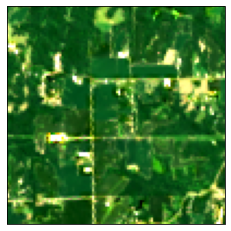

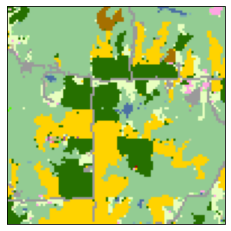

In [8]:
sample = next(iter(dataloader))

image = sample["image"][0]
label = sample["masks"][0]
bbox = sample["bbox"][0]

landsat.plot(image, bbox, projection, transform)
cdl.plot(label, bbox, projection, transform)